# Worst Place To Work (BR) 

Durante o mês de março de 2024, um usuário do Linkedin soltou uma enquete anônima com texto livre pra reclamar do lugar que você trabalha. Todas as entradas nesse dataset, que é uma planilha com quase 2k avaliações nesse momento (26/03/2024). [ref]

[ref]: https://docs.google.com/spreadsheets/d/1u1_8ND_BY1DaGaQdu0ZRZPebrOaTJekE9hyw_7BAlzw/htmlview?usp=sharing

A proposta desse notebook é realizar uma avaliação usando conceitos de Processamento de Linguagem Natural (NLP) para quantificar propriedades dessas avaliações, entre elas:

- Limpeza de dados não-estruturados
- Normalização de entidade nomeada (empresa) usando algoritmo greedy
- Nuvem de palavras com ngrams (busca de tópicos comuns)
- Aprendizagem não-supervisionada com representação visual de proximidade de empresas baseado em feedbacks negativos (t-SNE over tfidf/word2vec)

# Carregar dataset

In [1]:
import datetime
import pandas as pd

In [2]:
from nlp_tir import datasets

df = datasets.get_dataset_br_worst_places_to_work()
df = df.rename(
    columns={
        "Carimbo de data/hora": "timestamp",
        "Nome da empresa": "company",
        "Motivos": "reasons"
    }
)
print(df.iloc[0])
df = df.drop(0) # drop identification
df

timestamp                    CRIADO POR ANDERSON WEBER:
company      https://www.linkedin.com/in/andersonweber/
reasons                                             NaN
Name: 0, dtype: object


,timestamp,company,reasons
1,25/03/2024 17:31:26,grupofreela,chefe é um filinho de papai que fica brincando...
2,25/03/2024 19:04:53,/r/brdev,Só tem frustrado arrogante e chupa rola de IA.
3,25/03/2024 19:07:43,/r/brdev,como aprender a programar
4,18/03/2024 09:48:27,200dev,Gestão fraca. Fazem joguinhos com a equipe. Nã...
5,25/03/2024 15:02:27,200dev,"Falta de feedbacks, demissão sem explicação ne..."
...,...,...,...
1913,26/03/2024 23:11:24,Uranet,Call center
1914,26/03/2024 23:11:25,CERC,"Simplesmente um dos piores RH que eu conheci, ..."
1915,26/03/2024 23:11:41,viggo intermediações,cultura do medo; alta rotatividade; quem não v...
1916,26/03/2024 23:11:48,Falconi,Todo dia muda seus processos organizacionais d...


In [3]:
# Fix type df.timestamp column to be a datetime
df["timestamp"] = df.timestamp.apply(lambda x: datetime.datetime.strptime(x, "%d/%m/%Y %H:%M:%S"))

In [4]:
df.describe()

,timestamp
count,1917
mean,2024-03-22 04:15:59.206051072
min,2024-03-18 08:39:30
25%,2024-03-18 11:45:31
50%,2024-03-20 12:39:32
75%,2024-03-25 18:28:37
max,2024-03-26 23:12:38


# Normalização de dados

## Remover ruído

Definição de ruído nesse caso: pessoas que só queriam visualizar ou deram razões pouco significativas pra continuar na análise. Estimei uma eurística com duas regras:

1. O campo empresa e motivos foram preenchidos com o mesmo conteúdo;
2. O campo motivos tem menos de 6 caracteres.

In [5]:

noise_query = (df.company.str.lower() == df.reasons.str.lower()) | (df.reasons.str.len() <= 6) 
df_noise = df[noise_query]
display(df_noise)
print("Registros a serem removidos: ", len(df_noise))

,timestamp,company,reasons
17,2024-03-25 17:37:13,a,a
253,2024-03-18 22:09:55,Bla,Ble
618,2024-03-25 17:33:03,Ff,Ff
948,2024-03-25 19:30:12,LalalandTeste,teste
990,2024-03-18 12:19:44,Luz Engenharia Financeira,Todos
1009,2024-03-18 11:09:49,Matheus,Ok
1044,2024-03-25 19:11:36,Milagre,teste
1087,2024-03-18 20:00:30,Não conheço,abc
1097,2024-03-18 11:52:06,Nenhuma,Nenhum
1176,2024-03-25 18:00:42,P,P


Registros a serem removidos:  21


In [6]:
df = df[~noise_query].dropna()

## Normalizar empresas

- Colocar tudo em caixa baixa e remover pontuação
- Aplicar normalização de entidade usando tradução via aliases (hand-written rule)

In [7]:
import string

translation_punctuation = str.maketrans({c: " " for c in string.punctuation})

In [8]:
"celulas(Setores)".translate(translation_punctuation)

'celulas Setores '

In [23]:
from collections import Counter
from sklearn.feature_extraction.text import strip_accents_ascii
# after lower + strip + remove dots
aliases_map = {
    # normalized -> aliases
    "xp": ["xp investimentos", "xp inc"],
    "btg pactual": ["btg"],
    "itau": ["itau unibanco"],
    "localiza co": ["localizaco"],
    "compass uol": ["compasso uol", "compassuol"],
    "f1rst empresa do santander": ['f1rst digital services', 'f1rst tecnologia banco santander', 'f1rst tecnologia santander'],
    "vivo": ["vivo telefonica brasil"]
}

def text_series_normalizer(series: pd.Series):
    return (
        series
        .str.translate(translation_punctuation)
        .str.lower()
        .str.strip()
        .replace(regex=r"\s+", value=" ")  # remove duplicated space
        .apply(lambda c: strip_accents_ascii(c) if isinstance(c, str) else c)
        .apply(lambda c: translate_map.get(c, c))
)

translate_map = {
    alias: normalized_term
    for normalized_term, aliases in aliases_map.items()
    for alias in aliases
}

company_normalized = text_series_normalizer(df.company)

In [20]:
df.company = company_normalized

## Normalizar motivos

- Aplicar mesmas regras de normalização de texto anterior, sem a normalização de entidade
- Agrupar motivos pelas mesmas empresas

In [21]:
df.reasons = text_series_normalizer(df.reasons)
df

,timestamp,company,reasons
1,2024-03-25 17:31:26,grupofreela,chefe e um filinho de papai que fica brincando...
2,2024-03-25 19:04:53,r brdev,so tem frustrado arrogante e chupa rola de ia
3,2024-03-25 19:07:43,r brdev,como aprender a programar
4,2024-03-18 09:48:27,200dev,gestao fraca fazem joguinhos com a equipe nao ...
5,2024-03-25 15:02:27,200dev,falta de feedbacks demissao sem explicacao nen...
...,...,...,...
1913,2024-03-26 23:11:24,uranet,call center
1914,2024-03-26 23:11:25,cerc,simplesmente um dos piores rh que eu conheci p...
1915,2024-03-26 23:11:41,viggo intermediacoes,cultura do medo alta rotatividade quem nao ven...
1916,2024-03-26 23:11:48,falconi,todo dia muda seus processos organizacionais d...


In [22]:
df_agg = (
    df.groupby(["company"], as_index = False)
      .agg(reasons=("reasons", ' '.join), count=("company", "count"))
      .sort_values(by="count", ascending=False)
)
with pd.option_context('display.max_colwidth', 200,
                       'display.max_columns', None,
                       'display.max_rows', None):
    display(df_agg.head(20))

,company,reasons,count
230,ci t,100 toxica lideres de equipe totalmente despreparados salario fraco em relacao ao mercado pl nem preciso comentar so compensa se voce for vir senior e olhe la te colocam em projetos internacionais...,36
13,accenture,empresa boa pra amadurecer mas salario abaixo do mercado e muita pressao em cima dos projetos e a empresa com maior pressao que ja trabalhei e nao e de forma saudavel pessimos salarios ma lideranc...,30
576,itau,desorganizacao e hierarquia pressao e cultura me contrataram e quando entrei nao tinha nada pra fazer e ai me demitiram mesmo eu vendo que tinha necessidade das minhas skills em outras squads nao ...,23
1121,wise system,o dono dessa empresa se comporta como um ditador uma empresa de software onde tem 2 devs o dono e um jr nao entregam o que prometem para os clientes quando tem problemas no sistema o proprio supor...,23
522,ibm,trabalhei no setor de consulting nao ha plano de carreira funcionarios incriveis estagnados por 2 3 ou mais anos se quiser progredir precisa sair da empresa os funcionarios sao explorados os clien...,21
1132,xp,inumeros casos de burnout salario baixo e cultura de politicagem associada ao bonus desonestidade gestao amadora a remuneracao com base no bonus e uma piada e irao sugar todo o seu tempo ambiente ...,20
960,stefanini,empresa gigante celulas setores competitivas internamente jogacao de batata quente a empresa fatura bilhoes e nunca pagou plr gestores toxicos a regra e sugar o colaborador ao maximo nao recomendo...,20
966,stone,falsa cultura empresa de politicagem e gente mal carater em posicao de lideranca o cto eh uma piada de mal gosto pressao psicologica assedio moral e chantageem emocional com o colaborador apesar d...,18
461,grao de gente,posicoes de liderancas assumidas por cargos familiares ou pessoas totalmente desqualificadas o cto que assumiu a grao mkt systems e um lunatico que nao sabe o minimo de lideranca gestao organizaca...,16
298,dataprev,diretoria e lideres ignoram corpo funcional quanto a melhorias de condicoes de trabalho e reconhecimento nao ha crescimento na carreira a politica de amizade e grupos se sobrepoem ao valores tecni...,16


# Análise núvem de palavra das 20 empresas mais citadas

- Avaliação com TF-IDF dos termos mais impactantes nas avaliações das 20 empresas com mais citações
- Geração de uma nuvem de palavras representantes essa avaliação

In [65]:
from nltk.corpus import stopwords

n_companies = 20 

# palavras sem muito significado, mas muito frequentes
my_stop_words = [
    "empresa",
    "cultura",
    "funcionarios",
    "gestores",
    "trabalhar",
    "ambiente",
    "gestao",
    "pessoas",
    "trabalho",
    "pra",
    "todos",
    "todo",
]

stops = [strip_accents_ascii(w) for w in stopwords.words('portuguese')]
stops.extend(my_stop_words)
corpus = df[df.company.isin(df_agg.head(n_companies).company.to_list())].reasons.to_list()

In [66]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,3), stop_words=stops)
vectors = vectorizer.fit_transform(corpus)
vocabulary = vectorizer.get_feature_names_out()
df_term_frequencies = pd.DataFrame(vectors.todense().tolist(), columns=vocabulary).T.sum(axis=1) 
df_term_frequencies

10                             0.311469
10 comprava                    0.167131
10 comprava paes               0.167131
10 estagiarios                 0.148344
10 estagiarios treinamento     0.148344
                                 ...   
zero qualidade                 0.469280
zero qualidade vida            0.469280
zero respeito                  0.122277
zero respeito colaboradores    0.122277
zona                           0.311969
Length: 12088, dtype: float64

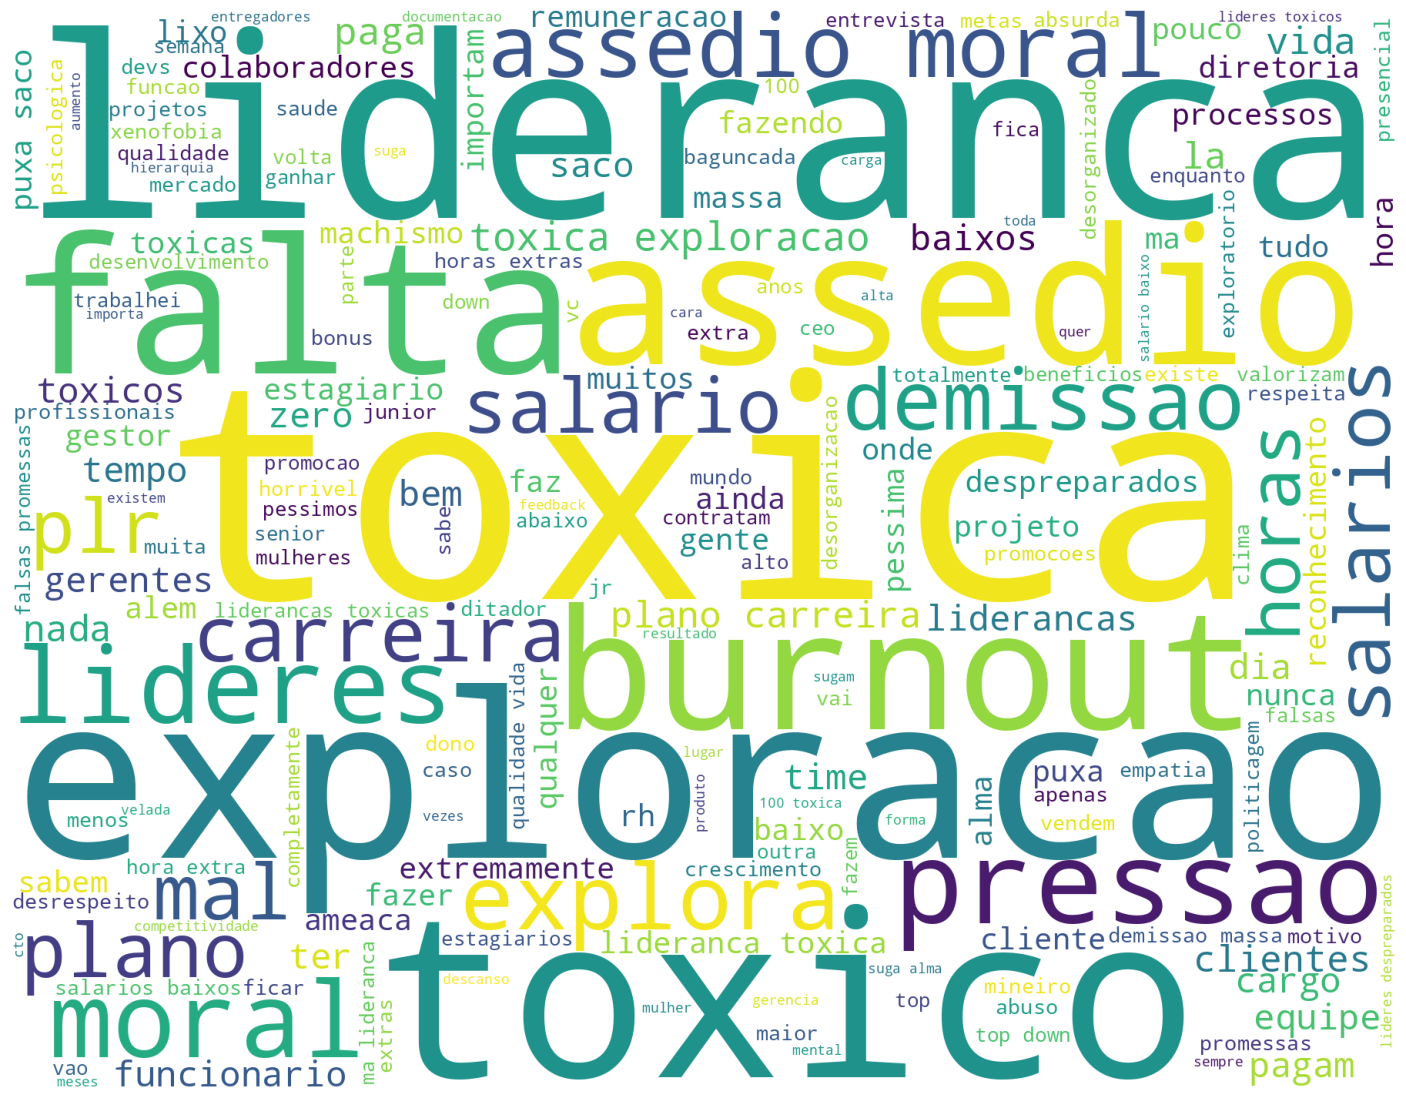

In [67]:
import matplotlib.pyplot as plt 
from wordcloud import WordCloud

width = 18
height = 14
plt.figure(figsize=(width, height))
#text = 'all your base are belong to us all of your base base base'
wordcloud = WordCloud(
    stopwords=stops,
    width=1800,
    height=1400,
    background_color="white",
).generate_from_frequencies(df_term_frequencies)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()